# 장흥군청 민원 현황 분석 과제
### 2020. 01. 01 ~ 2020. 12.31 정보공개청구 민원 데이터

#### 상세 요청내용
- 정보공개 신청현황
- 유형별 분석 : 정보공개 유형, 월별,요일별, 부서별 현황, 부서별 정보공개 유형 등
- 처리결과 분석, 주요 민원 키워드 현황, 주요 현안 발생추이, 분야별 현안 통계, 분야별 키워드 빈출 순위 등 시각화

#### 추가 분석내용
- LDA기반 토픽모델링
- 토픽별 세부 시각화
- 토픽별 내부 키워드 간 상관관계 및 연관단어에 대한 구조화

# 분석절차

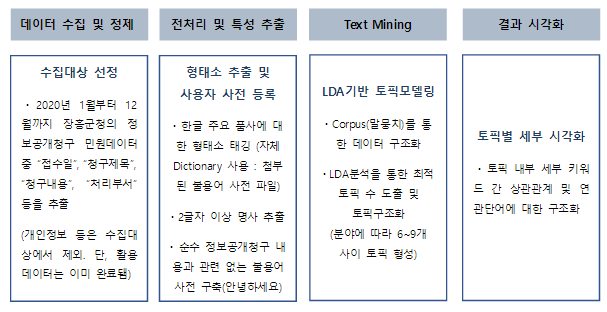

# 0. 패키지 임포트

#### 분석 환경
- anaconda python 3.9.7
- JDK 17.0.2
- JPYPE1 1.3.0 cp39
- 각 컴퓨터 환경에 따라 버전 차이가 심하기 때문에 테스트가 필요한 부분

In [7]:
# ! pip install konlpy
# ! pip install JPype1-1.3.0-cp39-cp39-win_amd64.whl 
# ! pip install wordcloud
# ! pip install gensim
# ! pip install pyLDAvis

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import datetime
from collections import Counter

from konlpy.tag import Okt, Kkma
from nltk import sent_tokenize, word_tokenize
import nltk
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

from nltk.corpus import stopwords
# from tensorflow.keras.preprocessing.text import Tokenizer
# from gensim.models.word2vec import Word2Vec
from collections import Counter

import matplotlib
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rc('font',family='NanumGothic')
plt.rc('font',family='NanumGothic')
from wordcloud import WordCloud
import platform

import gensim
import gensim.corpora as corpora
from gensim import corpora,models
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel

In [9]:
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')

# 1. 데이터 불러오기

In [10]:
df = pd.read_excel("청구서전체현황(2020-01-01_2020-12-31).xlsx") # 장흥군청 정고공개 데이터
df.head()

,접수번호,접수일,청구인,구분,청구제목,청구내용,공개방법,처리부서,결정구분,공개내용,...,처리완료일자,처리기간,부존재사유,연장통지일자,다중처리여부,수수료 감면 신청여부,수수료 감면 사유,수수료금액,수수료납부여부,수수료납부형태
0,7367113,2020.12.31,김슬기,개인(내국인),2020년 12월 신규 일반 음식점 현황요청합니다.(빠른처리부탁드립니다),"2020년 12월에 영업을 시작한 일반 음식점의 \n\n- 연번(개수), 업소명, ...",전자파일,전라남도 장흥군 보건소,공개,2020년 12월에 영업을 시작한 일반음식점 현황을 붙임과 같이 공개합니다.,...,2021.01.11,7일,NaN,NaN,NaN,N,NaN,0,Y,NaN
1,7365747,2020.12.31,노진백,개인(내국인),정보공개청구,구급활동일지 2019. 10. 9. 18:30,사본·출력물,전라남도 장흥군 민원봉사과,NaN,NaN,...,2020.12.31,NaN,NaN,NaN,NaN,N,NaN,0,NaN,NaN
2,7365424,2020.12.31,정순학,개인(내국인),문병철(690308)님 관련 경찰서류 정보공개 요청드립니다.(장흥경찰서),故 문병철(69.03.08)님 관련 경찰서류 정보공개 요청드립니다.\n\n최초사건발...,전자파일,전라남도 장흥군 민원봉사과,NaN,NaN,...,2021.01.11,7일,NaN,NaN,NaN,N,NaN,0,NaN,NaN
3,7365358,2020.12.31,방기송,개인(내국인),2020년 하반기(7월1일부터 12월31일) 신설당구장 현황 정보공개청구,"안녕하세요,\n주기적으로 관내 신설 당구장 정보공개를 청구하는 월간 큐스포츠입니다....",전자파일,전라남도 장흥군 스포츠산업단,공개,붙임 파일 참고 바랍니다.,...,2021.01.05,3일,NaN,NaN,NaN,N,NaN,0,Y,NaN
4,7365033,2020.12.31,김재주,개인(내국인),"각 도, 시, 군, 구의 자체적인 인터넷 민원 운영 현황 요청",안녕하세요\n코로나 시국에 불철주야 고생 많으신 공무원분들을 항상 응원합니다.\n\...,전자파일,전라남도 장흥군 총무과,공개,우리군 인터넷 민원(군수에게 바란다) 운영 현황,...,2021.01.11,7일,NaN,NaN,NaN,N,NaN,0,Y,NaN


# 1-2. 결측치&이상치 제거

In [4]:
df.isnull().sum()

접수번호                    0
접수일                     0
청구인                     0
구분                      0
청구제목                    0
청구내용                    0
공개방법                    0
처리부서                   28
결정구분                  489
공개내용                  520
비공개(부분 공개)내용 및 사유    1549
비공개사유                1547
결정통지일                 320
공개일                   533
공개형태                  491
교부방법                  491
처리상태                    0
청구방법                    0
처리자                    16
처리기한                    0
처리완료일자                  0
처리기간                   58
부존재사유                1452
연장통지일자               1622
다중처리여부               1561
수수료 감면 신청여부             0
수수료 감면 사유            1616
수수료금액                   0
수수료납부여부               521
수수료납부형태              1632
dtype: int64

### 결측치에 대한 장흥군청 주무관님 답변
**1. 처리자의 이름은 존재하지만, 처리부서는 결측치인 경우 오류인가요?**    
처리부서 공란은 취하등의 사유로 부서 지정이 안된 경우  

**2. [처리상태] 열의 종결처리/공개완료/통지완료 간의 의미 차이가 무엇인가요?**    
종결처리 : 2회 이상 정당한 사유가 없는 청구    
공개완료 : 기관에서 민원인이 청구한 내용 공개(비공개,부분공개,비공개)    
통지완료 : 기관에서 결정통지서를 청구인에게 통지한 상태  

**3. [처리기간]의 기준이 [처리상태]의 단계까지로 정해지는 것 맞나요? 민원 종결이나 공개완료가 끝나지 않더라도 완료된 처리 상태까지의 영업일 수인가요?**    
처리기간 접수일로부터 10일이며 부존재 처리는 7일이전에 완료하여야 하며 연장의 경우는 1회 가능하면 10일 추가됩니다    

**4.[공개 방법] 열의 전자파일/사본·출력물/열람·시청은 민원인이 요청한 형태인가요?     
[공개 형태]는 공개가 결정된 후에 민원인에게 공개된 형태일까요?**      
네 

**5. [다중처리여부] 민원에서 다중처리가 어떠한 의미인지 간단한 설명 부탁드립니다.**    
청구인이 한 개의 청구가 아닌 경우    
다른 분류의 내용이 여러개인 경우     
해당 청구건을 처리 하는 총괄부서 - 주관부서로 지정 


**다양한 결측치가 있었으나 별도의 처리가 필요한 데이터가 아니었음**

# 2. 탐색적 분석

Text(0, 0.5, '건수')

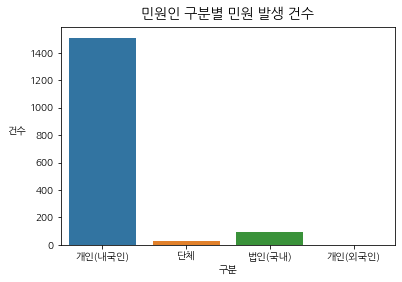

In [17]:
# 1. 민원인 구분별 그래프
sns.countplot(x=df['구분'])
plt.title("민원인 구분별 민원 발생 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)

In [15]:
# 2-1. 월별 접수 건수 그래프

# 접수일의 월만 추출해서 새로운 리스트 생성
month_list = []
for i in range(len(df['접수일'])):
    month = df['접수일'][i][5:7]
    month_list.append(month)

df['월'] = month_list # 기존의 df에 각 월을 붙여줌

month_df=pd.DataFrame(df['월'].value_counts().sort_index()) # 월별로 정렬

# 추후 시각화를 위해 1, 2, 3 ... 에 월을 붙여줌
for i in range(1,13):
    if i<=9:
        month_df.rename(index={'0'+str(i) : '0'+str(i)+'월'},inplace=True)
    else:
        month_df.rename(index={str(i): str(i)+'월'},inplace=True)

Text(0.5, 0, '월')

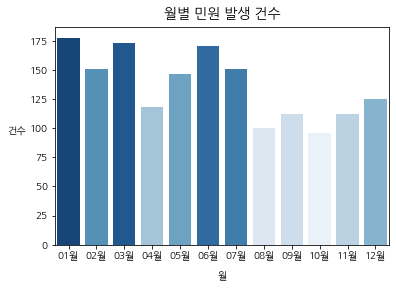

In [18]:
data = df.groupby("월").size() # count와 다르게 size는 NaN까지 포함
pal = sns.color_palette("Blues_r",len(month_df)) # 컬러팔레트 지정
rank = data.argsort().argsort() # argsort() : 해당 데이터 셋에서 크기가 작은 값부터 순서대로 데이터의 index를 반환하는 함수(index는 0부터 시작)
sns.barplot(x=month_df.index,y=month_df['월'], palette = np.array(pal[::-1])[rank])
# 빈도수가 많을 수록 진하게 설정
plt.title("월별 민원 발생 건수", fontsize=14, pad=10 )
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("월", rotation=0, labelpad=10)

- 월평균 약 136건의 민원이 접수됨
- 1월에 접수된 민원이 총 178건으로 분석 기간 중 가장 많은 민원이 접수 되었으며, 10월이 96건으로 가장 적은 민원이 접수됨
- 분기별/월별 민원 발생 현황을 분석한 결과 양적인 측면에서 민원의 계절성이 존재한다고는 판단하기 어려우나, 상반기에 민원이 집중된 경향을 보임

Text(0.5, 0, '분기')

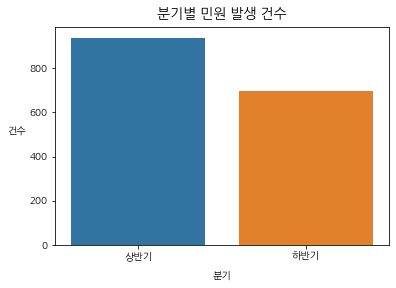

In [20]:
# 2-2. 분기별 접수 건수 그래프 (상/하반기)

df_quater = df.astype({'월':int}) # 기존의 '월'을 int 형으로 변환

# quater 1~6월 상반기, 7~12월 하반기
quater = [] 
for i in range(len(df)):
    if df_quater['월'][i] < 7 : 
        quater.append('상반기')
    else:
        quater.append('하반기')

df_quater['상/하반기'] = quater
        
proc = ['상반기', '하반기']
sns.countplot(x=df_quater['상/하반기'], order = proc)
plt.title("분기별 민원 발생 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("분기", labelpad=10)

- 분기별 민원 건수를 비교한 결과 상반기 일평균 5.15건에서 하반기 3.8건으로 감소한 것으로 나타남
- 결과 양적인 측면에서 민원의 계절성이 존재한다고는 판단하기 어려우나, 상반기 민원이 집중된 경향을 보임

Text(0.5, 0, '분기')

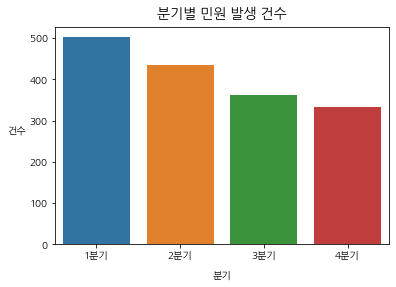

In [22]:
# 2-3. 분기별 접수 건수 그래프 (4분기)

quater2 = []

for i in range(len(df)):
    if df_quater['월'][i] < 4 : 
        quater2.append('1분기')
        
    elif df_quater['월'][i] < 7 :
        quater2.append('2분기')
        
    elif df_quater['월'][i] < 10 :
        quater2.append('3분기')
        
    else:
        quater2.append('4분기')

df_quater['분기'] = quater2       

proc2 = ['1분기','2분기','3분기','4분기']
sns.countplot(x=df_quater['분기'], order=proc2)
plt.title("분기별 민원 발생 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("분기", labelpad=10)

- 위의 분기에서 조금더 세분화했으나 큰 차이는 없었음

Text(0.5, 0, '요일')

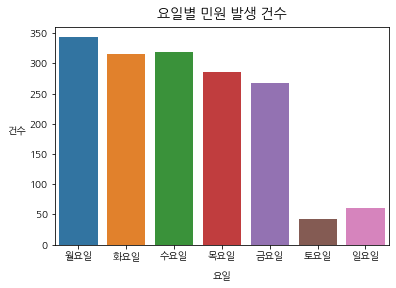

In [23]:
# 3. 요일별 건수 그래프
df['요일'] = pd.to_datetime(df['접수일']).dt.day_name() # 접수일의 요일 추출

df['요일'] = df['요일'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                 ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']) # 한국어로 변경

요일 = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']
sns.countplot(x=df['요일'],order=요일)
plt.title("요일별 민원 발생 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("요일", labelpad=10)

- 평일에 비해서 주말이 특히나 적은 접수를 보이고 있음
- 대다수가 온라인 접수를 하고 있긴하나 영향을 미치지 않는 것으로 추측

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

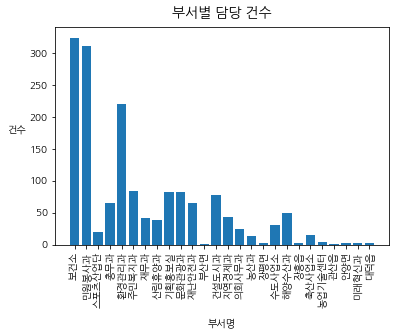

In [24]:
# 4. 부서별 건수 그래프
depart = list(df['처리부서'].dropna()) # 결측치가 존재하므로 제거하고 시각화

# 전라남도 장흥군는 모두 같은 사실이기때문에 제거하고 추출
division = []
for i in range(len(depart)):
    result = depart[i][9:]
    division.append(result)

division_count = Counter(division) # 부서 count해서 딕셔너리 타입으로 반환

division_keys = division_count.keys()
division_values = division_count.values()

plt.bar(division_keys,division_values)
plt.title("부서별 담당 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("부서명", labelpad=10)
plt.xticks(rotation=90) # 부서명이 길기때문에 x축 회전 

- 하단에 추가 분석을 진행함

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '보건소'),
  Text(1, 0, '민원봉사과'),
  Text(2, 0, '환경관리과'),
  Text(3, 0, '주민복지과'),
  Text(4, 0, '문화관광과'),
  Text(5, 0, '기획홍보실'),
  Text(6, 0, '건설도시과'),
  Text(7, 0, '총무과'),
  Text(8, 0, '재난안전과'),
  Text(9, 0, '해양수산과')])

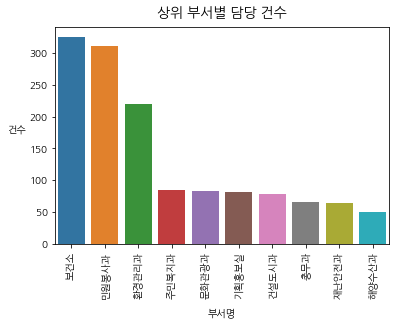

In [25]:
# 4-1. 상위 부서만 시각화

division_df = pd.DataFrame(division) # 부서만을 추출한 리스트를 데이터프레임화
count_1 = [1]*len(division_df) # count 하기 위해서 옆 행에 1을 붙임
division_df['count'] = count_1

top_division = division_df.groupby(by=[0],as_index=False).sum()
top_division.sort_values(by='count',ascending=False,inplace=True) # 내림차순 정렬

top_division = top_division[top_division['count']>=50] # 50개 이상 민원만 추출
sns.barplot(x=top_division[0], y=top_division['count'])

plt.title("상위 부서별 담당 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("부서명", labelpad=10)
plt.xticks(rotation=90)

- 전체 데이터 1,634개 중 민원 처리 부서에 대한 데이터 28개의 값이 존재하지 않음. 대체로 ‘‘처리상태’가 ‘청구취소’ 또는 ‘종결처리’로, 부서가 지정되기 전 상태가 변경된 경우로 추측됨. 이 경우는 삭제하고 분석을 진행함.
- 총 1,606건 중 73건의 민원은 여러 개의 부서가 함께 청구 건을 처리하였으나, 주관부서만 고려된 데이터로 실제 부서의 청구 건 수와 차이가 있을 수도 있음.
-장흥군 민원은 총 26개 부서에서 처리되었으며, 상위 3개 부서(보건소, 민원봉사과, 환경관리과)의 민원이 전체 민원의 52.39%를 차지하였고, 상위 10개 부서의 민원이 전체 민원의 83.48%를 차지하는 것으로 나타나 민원이 일부 부서에 편중되고 있음

In [16]:
top = ['보건소',' 민원봉사과', '환경관리과']

for i in top:
    print('처리부서==전라남도 장흥군 ' + i)

처리부서==전라남도 장흥군 보건소
처리부서==전라남도 장흥군  민원봉사과
처리부서==전라남도 장흥군 환경관리과


Text(0.5, 0, '요일')

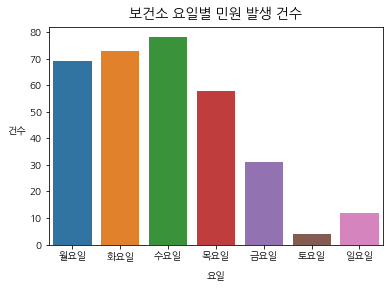

In [26]:
# 4-2. 상위기관 1 : 보건소
df_hp = df.query("처리부서=='전라남도 장흥군 보건소'")
요일 = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']
sns.countplot(x=df_hp['요일'],order=요일)

plt.title("보건소 요일별 민원 발생 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("요일", labelpad=10)

Text(0.5, 0, '요일')

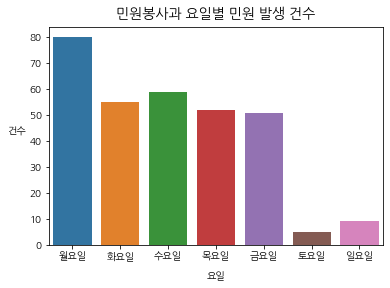

In [27]:
# 4-3. 상위기관 2 : 민원봉사과
df_vo = df.query("처리부서=='전라남도 장흥군 민원봉사과'")
요일 = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']
sns.countplot(x=df_vo['요일'],order=요일)

plt.title("민원봉사과 요일별 민원 발생 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("요일", labelpad=10)

Text(0.5, 0, '요일')

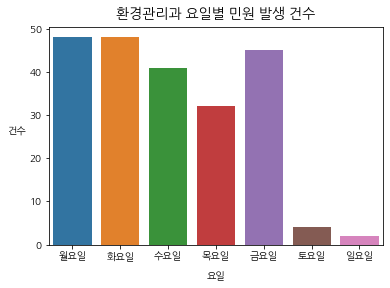

In [28]:
# 4-3. 상위기관 3 : 환경관리과
df_en = df.query("처리부서=='전라남도 장흥군 환경관리과'")
요일 = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']
sns.countplot(x=df_en['요일'],order=요일)

plt.title("환경관리과 요일별 민원 발생 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)
plt.xlabel("요일", labelpad=10)

- 접수 상위 부서만을 추가 분석을 진행하려 했으나 요일별에 대한 정보의 한계가 있었음
- 위의 특징과 같이 평일보다 주말에 민원 접수가 적음

Text(0, 0.5, '건수')

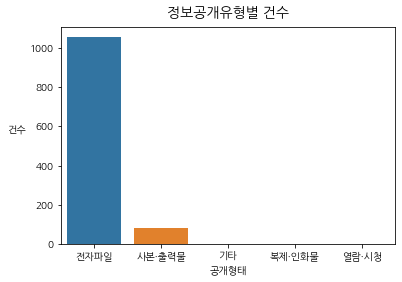

In [29]:
# 5. 정보공개유형별 건수
sns.countplot(x=df['공개형태'])
# df['공개형태'].value_counts()

plt.title("정보공개유형별 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)


Text(0, 0.5, '건수')

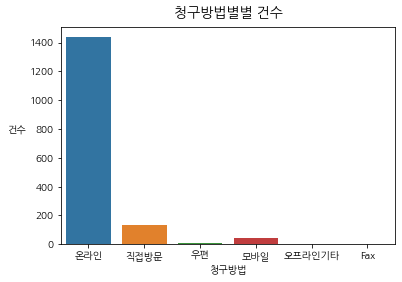

In [30]:
# 6. 청구방법별 건수
sns.countplot(x=df['청구방법'])

plt.title("청구방법별별 건수", fontsize=14, pad=10)
plt.ylabel("건수", rotation=0, labelpad=13)

[Text(0.5, 1.0, '청구방법별 민원 건수')]

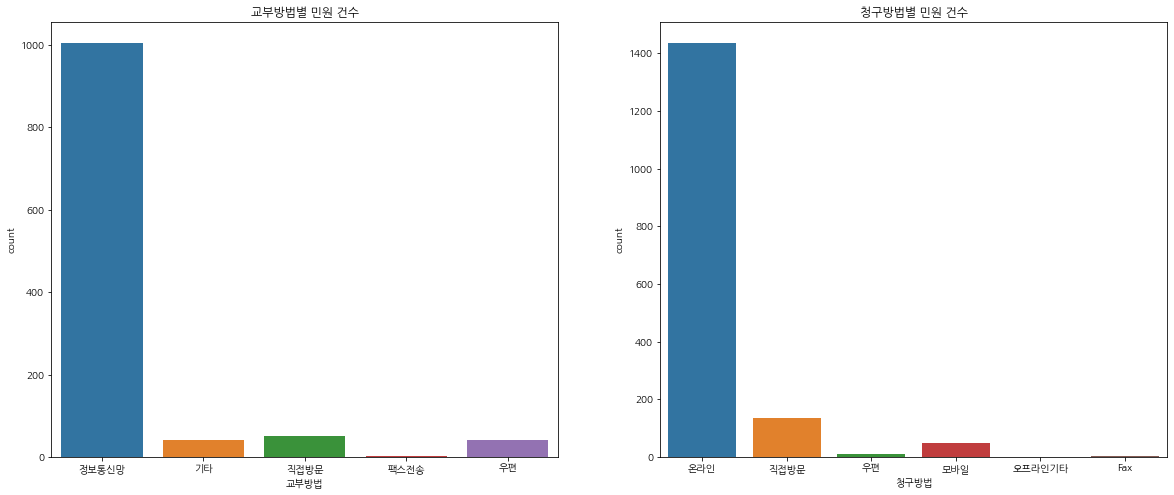

In [34]:
# 7. 민원 교부방법
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,8)

sns.countplot(x=df['교부방법'],ax=ax[0])
sns.countplot(x=df['청구방법'],ax=ax[1])

ax[0].set(title="교부방법별 민원 건수")
ax[1].set(title="청구방법별 민원 건수")

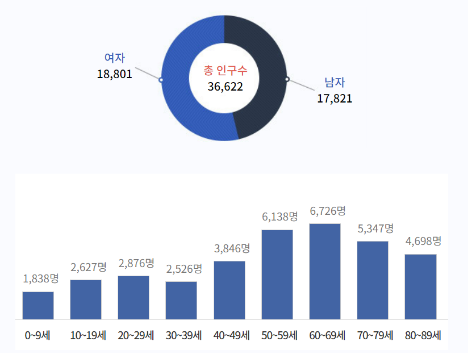

- 정보공개 청구방법에 직접방문, 온라인, 우편 등이 있는데 주로 온라인을 통해 청구하고, 온라인을 통해 정보를 통지하고 있음
- 장흥군청은 50세 인구 비중이 약 62%로 연령대가 높은 특징을 가지고있음
- 직접 방문의 비율이 높을 것으로 예상했으나 온라인이 월등히 많은 비율을 차지함


In [23]:
# 8. 처리상태
df['처리상태'].value_counts()

공개완료          1099
정보부존재통지완료      178
종결처리           146
청구취하           117
부서처리자지정         30
통지완료            26
결재완료            10
이송완료             6
결재중              5
진정질의통지완료         4
처리부서지정           4
이송입력완료           3
정보부존재결재완료        2
결정입력완료           2
수수료10일초과예정       1
부서처리자반려          1
Name: 처리상태, dtype: int64

- 정보공개청구 민원만을 분석하였기 때문에, 특별히 지연되는 점은 없었음
- 주무관님의 답변 중 '처리기간 접수일로부터 10일이며 부존재 처리는 7일이전에 완료하여야 하며 연장의 경우는 1회 가능하면 10일 추가됩니다.'에서 참고할 수 있음
- 주택과, 건축과, 건설관리과 등 다양한 부서의 민원을 분석한다면 지연 통계에서 의미있는 인사이트를 도출 할 수 있을 것으로 기대

# 3. WordCould 시각화


In [9]:
df['청구_text']=df['청구제목']+df['청구내용'] 
df['청구_text'].head()
# 데이터의 특징 상 제목에 모든 요청을 포함 하는 경우가 있기 때문에 제목과 내용을 모두 합쳐서 분석함

0    2020년 12월 신규 일반 음식점 현황요청합니다.(빠른처리부탁드립니다)2020년 ...
1                      정보공개청구구급활동일지 2019. 10. 9. 18:30
2    문병철(690308)님 관련 경찰서류 정보공개 요청드립니다.(장흥경찰서)故 문병철(...
3    2020년 하반기(7월1일부터 12월31일) 신설당구장 현황 정보공개청구안녕하세요,...
4    각 도, 시, 군, 구의 자체적인 인터넷 민원 운영 현황 요청안녕하세요\n코로나 시...
Name: 청구_text, dtype: object

In [10]:
clean_data = df['청구_text'].replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',regex=True) # 한글과 띄어쓰기를 제외한 모든 글자 빈칸으로 제거
clean_data

0           년   월 신규 일반 음식점 현황요청합니다  빠른처리부탁드립니다     년 ...
1                         정보공개청구구급활동일지                   
2       문병철        님 관련 경찰서류 정보공개 요청드립니다  장흥경찰서   문병철 ...
3           년 하반기  월 일부터   월  일  신설당구장 현황 정보공개청구안녕하세요 ...
4       각 도  시  군  구의 자체적인 인터넷 민원 운영 현황 요청안녕하세요 코로나 시국...
                              ...                        
1629    기초자치단체별로 등록되어 있는 비영리단체의 수기초자치단체 보조금 지출 결정요인에 관...
1630      년   월 장흥군 보건소 및 보건지소 제약사별 처방 현황 신청  년   월 장흥...
1631    신규 개원 의료기관현황 정보공개 청구아래 신규 개원한 의원  개월  자료 부탁드립니...
1632        년 하반기 신고된 신규 당구장 현황 안녕하세요  본 월간 큐스포츠는     ...
1633                  목욕탕 사우나  찜질방상호 전화번호 주소 지번주소 로 해주세요 
Name: 청구_text, Length: 1634, dtype: object

In [19]:
# 문장 데이터 토크나이즈
okt=Okt() # Okt(Open Korean Text) : 트위터에서 만든 오픈소스 한국어 처리기

# 한 글자 포함한 리스트
okt_word=[]

for i in range(len(clean_data)):
    try:
        okt_word.append(okt.nouns(clean_data[i]))
    except Exception as e:
        continue
        
# 두 글자 이상 리스트
okt_word2=[]

for j in okt_word:
    word = [i for i in j if len(i) > 1]
    okt_word2.append(word)

print(okt_word2)

[['신규', '일반', '음식점', '현황', '요청', '처리', '영업', '시작', '일반', '음식점', '개수', '소명', '소재지', '주소', '소재지', '전화', '영업', '작일', '이전', '업체', '오픈', '신규', '업체', '자료', '요청', '가게', '양도', '포함', '영업', '작일', '기준', '오름', '차순', '정리', '양도', '업체', '파일', '정리', '주시', '모두', '활성화', '홈페이지', '공개', '자료', '링크', '정리', '감사', '자료', '수집', '요청', '수고'], ['정보공개', '청구', '구급', '활동', '일지'], ['문병철', '관련', '경찰', '서류', '정보공개', '요청', '장흥', '경찰서', '문병철', '관련', '경찰', '서류', '정보공개', '요청', '최초', '사건', '발생', '보고서', '수사', '보고서', '검사', '지휘', '유족', '목격자', '진술서', '현장사진', '약도', '부검', '감정', '시체', '검안', '법안', '감전', '감식', '보고서', '구급', '활동', '일지', '신고', '녹취록', '참고인', '진술조서', '상기', '서류', '포함', '발급', '경찰', '서류', '일체'], ['하반기', '신설', '구장', '현황', '정보공개', '청구', '기적', '관내', '신설', '구장', '정보공개', '청구', '월간', '스포츠', '전국', '구장', '무료', '발송', '구장', '당구', '호인', '생활', '체육', '동호', '당구', '대회', '당구', '소식', '칼럼', '용품', '정보', '전달', '호인', '소식', '무료', '제공', '위해', '관내', '하반기', '신설', '구장', '현황', '상호', '주소', '당구대', '연락처', '메일', '업무', '도움'], ['구의', '자체', '인터넷', '민원', '운영',

In [26]:
#불용어 파일 불러오기
stop_words_claim_list = open('stopwords.txt', mode='rt',encoding='utf-8') # 불러오기
stop_words_claim_list_total = stop_words_claim_list.read().splitlines() # 파일에서 한 줄씩 읽기
print(stop_words_claim_list_total)

['2020년', '현황', '대한', '있는', '바랍니다', '청구합니다', '부탁드립니다', '들을', '합니다', '공개', '요청', '수', '있습니다', '또는', '중', '귀', '감사합니다', '정보', '한', '요청합니다', '거고', '?', '정보공개를', '따른', '자료', '예산', '요', '운영', '정보를', '시', '감사하겠습니다', '주시기', '위한', '이라는', '같은', '들이', '자료를', '요청 드립니다', '살', '~', "''", '대해', '현재까지', '!', '알고', '2019년', '=====================================================================', '위해', '저를', '본', '관내', '기준', '안', '내', '위', '하고', '``', '같았던', '주시면', '필요한', '저랑', '한테', '된', '엑셀파일로', '후', '아래의', '관련하여', '@', '2020년도', '으로는', '입니다', '하는', '‘', '’', '“', '라는', '하던', '”', '다음과', '받은', '이에', '더', '조지훈', '드립니다', '것으로', '통해', '됩니다', '20년', 'church', '먼저', '총', '싶습니다', '무궁한', '현황에', '등의', '는', '정보공개청구를', '지자체의', '기원합니다', '특히', '좋고', '할', '등을', '은', '강한', '군', '해당 문서를', '서로', '부탁드리겠습니다', '>', '기관의', '리스트를', '항상', '많으십니다', '가지고', '주', '원하는', '31일까지', '오픈한', '관할', '아래와', '2018년', '2020', '신청합니다', '업이', 'ex', '나은', '질', '양식에', '보내주시면', '이후', '문서를', '1월', '발전을', '내용을', '신규 등록 및 지위 승계된', '5월', '저는', '

In [27]:
#불용어 처리 완료

result_word=[]

for i in range(len(okt_word2)):
    j=[]
    for word in okt_word2[i]:
        if word not in stop_words_claim_list_total:
            j.append(word)
    result_word.append(j)
print(result_word)

[['신규', '음식점', '영업', '시작', '음식점', '개수', '소명', '소재지', '주소', '소재지', '전화', '영업', '업체', '오픈', '신규', '업체', '가게', '양도', '영업', '오름', '차순', '정리', '양도', '업체', '파일', '정리', '주시', '활성화', '홈페이지', '링크', '정리', '수집'], ['구급', '활동', '일지'], ['문병철', '경찰', '서류', '장흥', '경찰서', '문병철', '경찰', '서류', '최초', '사건', '발생', '보고서', '수사', '보고서', '검사', '지휘', '유족', '목격자', '진술서', '현장사진', '약도', '부검', '감정', '시체', '검안', '법안', '감전', '감식', '보고서', '구급', '활동', '일지', '신고', '녹취록', '참고인', '진술조서', '상기', '서류', '발급', '경찰', '서류'], ['하반기', '신설', '구장', '기적', '신설', '구장', '월간', '스포츠', '구장', '무료', '발송', '구장', '당구', '호인', '생활', '체육', '동호', '당구', '대회', '당구', '소식', '칼럼', '용품', '전달', '호인', '소식', '무료', '제공', '하반기', '신설', '구장', '주소', '당구대', '연락처', '메일', '업무', '도움'], ['구의', '자체', '인터넷', '민원', '코로나', '시국', '불철', '주야', '고생', '공무원', '응원', '국민신문고', '민원', '기초', '지자체', '한정', '자체', '인터넷', '민원', '몇개', '시장', '청장', '군수', '서식', '부존재', '음으로', '문의사항', '문자', '전화'], ['소규모', '방지', '시설', '설치', '지원', '사업', '배출', '사업', '청수', '환경', '업체', '소규모', '방지', '시설', '설치', '지원', 

In [28]:
for ind, word in enumerate(result_word): # enumerate : 반복문 사용시 몇 번째 반복문인지 확인, 한 건별 불용어 처리 후 데이터
    print(ind,word)

0 ['신규', '음식점', '영업', '시작', '음식점', '개수', '소명', '소재지', '주소', '소재지', '전화', '영업', '업체', '오픈', '신규', '업체', '가게', '양도', '영업', '오름', '차순', '정리', '양도', '업체', '파일', '정리', '주시', '활성화', '홈페이지', '링크', '정리', '수집']
1 ['구급', '활동', '일지']
2 ['문병철', '경찰', '서류', '장흥', '경찰서', '문병철', '경찰', '서류', '최초', '사건', '발생', '보고서', '수사', '보고서', '검사', '지휘', '유족', '목격자', '진술서', '현장사진', '약도', '부검', '감정', '시체', '검안', '법안', '감전', '감식', '보고서', '구급', '활동', '일지', '신고', '녹취록', '참고인', '진술조서', '상기', '서류', '발급', '경찰', '서류']
3 ['하반기', '신설', '구장', '기적', '신설', '구장', '월간', '스포츠', '구장', '무료', '발송', '구장', '당구', '호인', '생활', '체육', '동호', '당구', '대회', '당구', '소식', '칼럼', '용품', '전달', '호인', '소식', '무료', '제공', '하반기', '신설', '구장', '주소', '당구대', '연락처', '메일', '업무', '도움']
4 ['구의', '자체', '인터넷', '민원', '코로나', '시국', '불철', '주야', '고생', '공무원', '응원', '국민신문고', '민원', '기초', '지자체', '한정', '자체', '인터넷', '민원', '몇개', '시장', '청장', '군수', '서식', '부존재', '음으로', '문의사항', '문자', '전화']
5 ['소규모', '방지', '시설', '설치', '지원', '사업', '배출', '사업', '청수', '환경', '업체', '소규모', '방지', '시설', '설치', 

897 ['택법', '시행', '적용', '사례', '택법', '시행', '개정', '불문', '지역', '주택조합', '조합원', '자격', '설립', '신청', '지역', '주택조합', '조합원', '세대주', '유지', '세대주', '세대', '변경', '조합원', '자격', '규정', '주택조합', '조합원', '근무', '질병', '치료', '유학', '결혼', '부득이', '사유', '세대주', '자격', '일시', '시장', '군수', '구청', '인정', '조합원', '자격', '예외', '사유', '규정', '청구인', '규정', '적용', '세대주', '유지', '문제점', '발견', '자격', '위기', '지역', '주택조합', '조합원', '예외', '규정', '적용', '구제', '사례', '배우자', '세대주', '기존', '세대주', '세대', '변경', '동거', '부부', '세대주', '세대', '중간', '변경', '사례', '인적', '사항', '개인정보', '내용']
898 ['담당자', '직접', '답변', '첨부파일', '내용', '마트', '아파트', '상가', '관등', '장애인', '전용', '주차', '구역', '적지', '장애인', '노인', '임산', '부등', '편의', '증진', '보장', '법률', '시행', '장애인', '전용', '주차', '구역', '주차', '방해', '행위', '과태료', '부과', '보건복지부', '장애인', '전용', '주차', '구역', '주차', '방해', '행위', '지침', '게시', '적용', '경고', '적용', '내용']
899 ['원본', '문서']
900 ['지자체', '참전', '유공', '수당', '문의', '지방자치단체', '전쟁', '참전', '유공', '참전', '명예', '수당', '참전', '수당', '이름', '전쟁', '참전', '유공', '수당', '라면', '지방자치단체', '구별', '참전', '수당', '금액', '지원', '대상', '지

1259 []
1260 ['민원', '업무', '수당', '부당', '송부', '고사항', '조사', '결과', '검토', '결과', '조치', '결과', '국민권익위', '상위', '기관', '송부', '민원', '업무', '수당', '부당', '고사항', '기관', '조사', '결과', '검토', '결과', '조치', '결과', '비공개', '부존재', '제시', '시기', '참고', '사항', '문의사항', '전화', '연결', '메일', '문의', '시기', '개인정보', '삭제', '시기', '내용', '비공개', '행정심판', '행정소송', '검토', '근거', '법령', '제시', '시기']
1261 ['발주', '공사', '공사', '관리자', '기관', '사비', '상위', '공사', '대상', '내용', '내용', '기관', '발주', '공사', '공사', '관리자', '세부', '내용', '기관', '기관', '공사', '총괄', '담당자', '담당자', '전화번호', '발주', '공사', '공사', '발주', '부서', '공사', '기간', '공사', '금액', '공사', '시설', '시공', '업체', '책임', '감리', '공사', '관리자', '현장', '대리인', '품질', '관리자', '안전', '관리자', '대상', '발주', '공사', '기관', '계약', '사비', '상위', '공사', '첨부', '파일', '양식', '제출', '참고', '사항', '비공개', '행정심판', '행정소송', '검토', '근거', '법령', '조항', '호목', '제시', '내부', '규정', '제시', '시기', '문의사항', '전화', '연결', '메일', '문의', '시기']
1262 ['영업', '고증', '제곱미터', '중식', '영업', '고증', '제곱미터', '중국', '식당', '주소', '평수', '전화번호']
1263 ['구의', '지역', '주택조합', '구의', '지역', '주택조합', '조사', '신청', '지역', '

In [39]:
# 단어별 빈도수 구하기
frequency_word=sum(result_word,[])
word_counts=Counter(frequency_word
                   )
print(word_counts.most_common(100)) # 상위 100개만 프린트
print('총 단어 수 : ' + str(len(word_counts))) # 총 단어 수 확인

[('사업', 830), ('업체', 782), ('시설', 771), ('내용', 651), ('기관', 590), ('주소', 586), ('등록', 491), ('신고', 488), ('지자체', 451), ('허가', 446), ('문서', 423), ('관리', 404), ('조사', 399), ('사항', 368), ('영업', 365), ('대상', 341), ('신청', 331), ('파일', 327), ('상금', 314), ('계획', 302), ('사용', 292), ('지역', 280), ('설치', 268), ('양식', 252), ('첨부', 250), ('기간', 247), ('식품', 244), ('음식점', 242), ('부서', 242), ('전화번호', 240), ('신규', 237), ('금액', 237), ('업무', 235), ('확인', 235), ('위탁', 234), ('검사', 229), ('사람', 229), ('시행', 227), ('민원', 221), ('계약', 213), ('담당자', 211), ('시기', 203), ('명령', 202), ('연구', 200), ('진행', 200), ('추진', 196), ('담당', 195), ('결과', 194), ('토양', 193), ('지원', 190), ('단체', 189), ('토양오염', 184), ('폐기물', 182), ('오염', 177), ('보건소', 172), ('목적', 170), ('환경', 166), ('연락처', 163), ('공무원', 162), ('지방자치단체', 160), ('전화', 159), ('발전', 158), ('사회', 157), ('위반', 156), ('기초', 153), ('생활', 152), ('면적', 149), ('제한', 148), ('건축', 147), ('공사', 145), ('연구소', 144), ('목록', 143), ('민간', 143), ('주시', 142), ('주택', 142), ('행정', 1

In [44]:
keyword_top_100=pd.DataFrame(word_counts.most_common(100), columns=['단어', '빈도'],index=range(1,101))
keyword_top_100=keyword_top_100.rename_axis('순번')
keyword_top_100.to_excel('keyword_top_100.xlsx') # 엑셀 시트로 확인

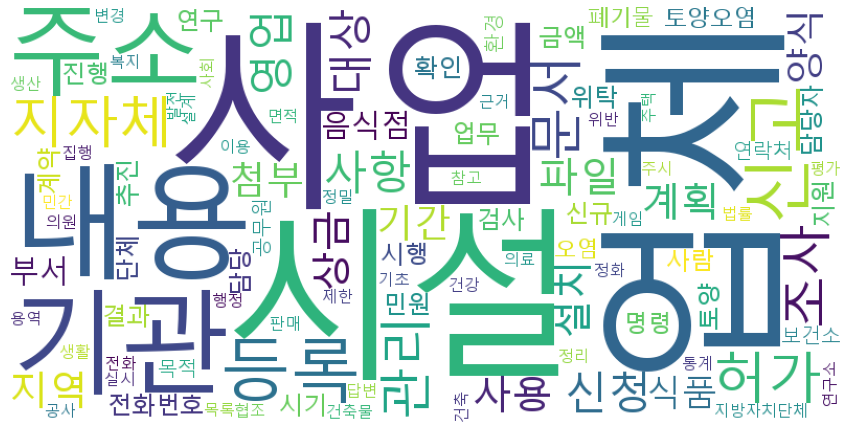

In [59]:
# Wordcloud 시각화

if platform.system() == 'Windows':   #윈도우의 경우
    font_path = "c:/Windows/Fonts/malgun.ttf"
elif platform.system() == "Darwin":   #Mac 의 경우
    font_path = "/Users/$USER/Library/Fonts/AppleGothic.ttf"
    

wordcloud=WordCloud(font_path= font_path, 
                    background_color="white",
                    max_words=100,
                    relative_scaling= 0.3,
                    width = 800,
                    height = 400
                 ).generate_from_frequencies(word_counts)  
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('claim_wordcloud.png')

# 4. LDA 토픽 모델링

In [67]:
dic = corpora.Dictionary(result_word) # corpora(분석할 문서들의 단어)
corpus = [dic.doc2bow(text) for text in result_word] # doc2bow : 단어를 숫자로 변환하고 카운트 알아내기

### 평가 방법
#### 1. Perplexity (혼란도)
- 특정 확률 모델이 실제도 관측되는 값을 얼맘나 잘 예측하는지를 뜻함
- 값이 작으면 토픽모델이 문서를 잘 반영할 수 있음

#### 2. Coherence (일관성)
- 모델링이 잘 되어있을수록 한 주제 안에 의미론적으로 유사한 단어끼리 모여있음
- 상위 단어 간의 유사도
- 문서 집합의 Coherence가 높아지면 monotonic해지는 문제점 발생, 정보의 양이 줄어듬
- 하지만 Coherence가 너무 낮아 정보들이 연관성이 없다면, 분석의 의미가 낮아짐

In [69]:
#모델링
topics_count=range(1,30) # 토픽 갯수 1~29까지 사이로 조정
perplexity_score=[] # 혼란도
coherence_score=[] # 일관성

# 토픽 개수 별 혼란도, 일관성 확인
for i in topics_count:
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=dic, passes=10,random_state=13)
    perplexity=ldamodel.log_perplexity(corpus)
    perplexity_score.append(perplexity)
    
    coherence=CoherenceModel(model=ldamodel,texts=result_word,dictionary=dic,coherence='c_v').get_coherence()
    coherence_score.append(coherence)
    
    print("topic count={0}".format(i))
    print('Perplexity:', perplexity)
    print('Coherence Score: ',coherence)
    print("-"*50)

topic count=1
Perplexity: -7.340299833241233
Coherence Score:  0.25207596649019537
--------------------------------------------------
topic count=2
Perplexity: -7.177857080958047
Coherence Score:  0.37384085304277026
--------------------------------------------------
topic count=3
Perplexity: -7.1294241280744375
Coherence Score:  0.35475801552549374
--------------------------------------------------
topic count=4
Perplexity: -7.056044583956378
Coherence Score:  0.3727661945602121
--------------------------------------------------
topic count=5
Perplexity: -7.005897202420926
Coherence Score:  0.37527009843949066
--------------------------------------------------
topic count=6
Perplexity: -6.984079066321187
Coherence Score:  0.3600270074798717
--------------------------------------------------
topic count=7
Perplexity: -6.935840385537253
Coherence Score:  0.36796310910818475
--------------------------------------------------
topic count=8
Perplexity: -6.9100009794808095
Coherence Score: 

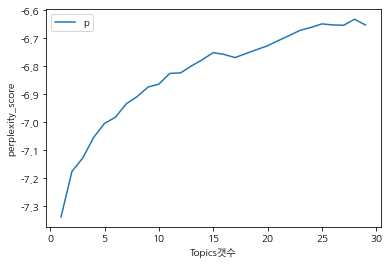

In [78]:
#복잡도 시각화
plt.plot(range(1,30),perplexity_score)
plt.xlabel("Topics갯수")
plt.ylabel("perplexity_score")
plt.legend(("perplexity_score"))
plt.show()

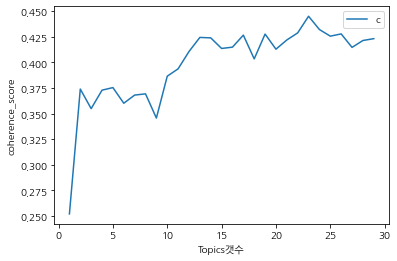

In [79]:
#일관성 시각화
plt.plot(range(1,30),coherence_score)
plt.xlabel("Topics갯수")
plt.ylabel("coherence_score")
plt.legend(("coherence_value"))
plt.show()

In [80]:
for inx,score in enumerate(coherence_score):
    print("Topic_count= ", inx, " Coherence Value= ", round(score, 4))

Topic_count=  0  Coherence Value=  0.2521
Topic_count=  1  Coherence Value=  0.3738
Topic_count=  2  Coherence Value=  0.3548
Topic_count=  3  Coherence Value=  0.3728
Topic_count=  4  Coherence Value=  0.3753
Topic_count=  5  Coherence Value=  0.36
Topic_count=  6  Coherence Value=  0.368
Topic_count=  7  Coherence Value=  0.3692
Topic_count=  8  Coherence Value=  0.3456
Topic_count=  9  Coherence Value=  0.3864
Topic_count=  10  Coherence Value=  0.3936
Topic_count=  11  Coherence Value=  0.4104
Topic_count=  12  Coherence Value=  0.4242
Topic_count=  13  Coherence Value=  0.4238
Topic_count=  14  Coherence Value=  0.4134
Topic_count=  15  Coherence Value=  0.4147
Topic_count=  16  Coherence Value=  0.4264
Topic_count=  17  Coherence Value=  0.4033
Topic_count=  18  Coherence Value=  0.4275
Topic_count=  19  Coherence Value=  0.4127
Topic_count=  20  Coherence Value=  0.4217
Topic_count=  21  Coherence Value=  0.4286
Topic_count=  22  Coherence Value=  0.4449
Topic_count=  23  Cohere

In [85]:
NUM_TOPICS = 7 #토픽 개수
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dic, passes=20) 
# passes는 알고리즘의 동작 횟수의미함.알고리즘이 결정하는 토픽의 값이 적절히 수렴할 수 있도록 충분히 적당한 횟수를 정해줘야 함

topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.033*"사업" + 0.017*"업체" + 0.015*"허가" + 0.014*"영업" + 0.014*"신고"')
(1, '0.033*"문서" + 0.023*"사업" + 0.017*"계약" + 0.012*"내용" + 0.012*"주택"')
(2, '0.049*"등록" + 0.028*"주소" + 0.023*"업체" + 0.018*"전화번호" + 0.018*"허가"')
(3, '0.017*"시설" + 0.012*"지자체" + 0.008*"도로" + 0.008*"단체" + 0.007*"안전"')
(4, '0.018*"시설" + 0.016*"기관" + 0.013*"위탁" + 0.013*"사람" + 0.009*"연구소"')
(5, '0.024*"내용" + 0.023*"상금" + 0.016*"신고" + 0.012*"민원" + 0.010*"기관"')
(6, '0.027*"업체" + 0.021*"시설" + 0.019*"검사" + 0.019*"명령" + 0.019*"토양"')


In [86]:
pyLDAvis.enable_notebook() # pyLDAvis : 모델링에서 최적화 시킨 토픽별 토픽을 대표하는 단어들을 반환한 후 PCA를 통해 2차원 mapping
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dic)
pyLDAvis.display(vis)